In [1]:
import pandas, matplotlib, copy,numba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import lmfit
import phast_functions

from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

# Plots required:

1. Aligned pulse
2. Exponential fitting + residual
3. Exponential + reflection fitting + residual
4. Bi-exponential + reflection fitting + residual
    1. model proposition with parameters indicated in the plot
5. Heat-maps all parameters
    1. tau
    2. amp
    3. mean
    4. std dev
    5. t_0
    6. t_1
    7. offset
    8. k
6. Non linearity plot, normalized X^2 vs amplitude

# Funtions and constants

In [147]:
x = np.arange(0,32)

PLOG = 0.2784645427610738

sample_rate = 80E6
ratio = 0.3

def get_arr(dt: str):
    return ','.join(["{}{:02}".format(a_,b_) for a_,b_ in zip([dt]*32,range(32))]).split(',')

def get_range(n: int, sample_rate: float):
    return [x * sample_rate for x in range(n)]

def exp_model(x, N: int, t0: float, amp: float, tau: float, offset: float):
    crrcn = np.zeros(np.shape(x))
    for t in x:
        if t < t0:
            crrcn[t] = offset
        elif t0 <= t:
            crrcn[t] = offset + amp * (np.exp(N) / (N ** N)) * ((t - t0) / tau) ** N * np.exp( - (t - t0) / tau) 
    return crrcn

@numba.njit
def biexp_model(x, N: float, t0: float, amp: float, tau: float, offset: float):
    crrcn = np.zeros(np.shape(x))
    norm = (-2 * tau**2 + np.exp((2 *(tau + tau * PLOG))/ tau)*(2 * tau**2 - 4 * tau *(tau + tau * PLOG) \
        + 4*(tau + tau * PLOG)**2))/ np.exp((4 *(tau + tau * PLOG))/ tau)
    for t in x:
        if t < t0:
            crrcn[t] = offset
        elif t0 <= t:
            crrcn[t] = offset + (amp * (np.exp((-2 * t + t0)/tau)*(-2 * np.exp(t0/tau)* tau**2 + 
                np.exp(t / tau)*(t**2 + t0**2 + 2 * t0 * tau + 2 * tau**2 - 2 * t * (t0 + tau))))) / norm
    return crrcn

def heat_map(data, colormap, fname, log = False, xlabel = 'X [cells]', ylabel= 'Y[cells]', blabel= 'Color bar'):
    image = np.empty((48, 64))
    image[:] = np.NaN
    for coor, val in data.items():
        image[int(coor.split(',')[1][:-2])][int(coor.split(',')[0][:-2])] = val
    
    cmap = matplotlib.cm.get_cmap(colormap).copy()

    cmap.set_bad(color='black')
    plt.imshow(image, origin= 'lower', cmap=cmap,
         norm=  colors.LogNorm(vmin=np.nanmin(image),vmax=np.nanmax(image)) if log else colors.Normalize(vmin=np.nanmin(image),vmax=np.nanmax(image)))
    cbar = plt.colorbar()

    cbar.set_label(blabel)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'plots/hm_{fname}.pdf', bbox_inches = 'tight')


# Load data

In [64]:
data = pandas.read_csv("data/fit_20210319_163519.csv", delimiter=',', nrows=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 82 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   # Run       1 non-null      float64
 1   Spill       1 non-null      float64
 2   Event       1 non-null      float64
 3   X           1 non-null      float64
 4   Y           1 non-null      float64
 5   Barycenter  1 non-null      float64
 6   peak_amp    1 non-null      float64
 7   Mean        1 non-null      float64
 8   Std         1 non-null      float64
 9   N           1 non-null      float64
 10  t0          1 non-null      float64
 11  amp         1 non-null      float64
 12  tau         1 non-null      float64
 13  offset      1 non-null      float64
 14  k           1 non-null      float64
 15  dt          1 non-null      float64
 16  bic         1 non-null      float64
 17  chisqr      1 non-null      float64
 18  d00         1 non-null      float64
 19  d01         1 non-null      float

# Pulse plots

## Experimental pulse shape

In [65]:
exp_data = data.iloc[0][get_arr('d')]
plt.plot(exp_data)
plt.xlabel(r'Time (Sampling Periods)',fontsize=12, labelpad=5)
plt.ylabel(r'Amplitude (ADC Value)',fontsize=12)
##plt.suptitle(r'Initial Coefficients Set', fontsize=16)
axes=plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * ratio)
plt.savefig('plots/exp_pulse.pdf', bbox_inches = 'tight')
plt.show()

## Exponential fitting

In [159]:
model = lmfit.Model(exp_model)
pars = model.make_params()
pars.add(name='N',      value=2, vary=False,    min=2,   max=2.1)
pars.add(name='t0',     value=7, vary=True,     min=0,  max=20)
pars.add(name='amp',    value=2000, vary=True,     min=1500,  max=5000)
pars.add(name='tau',    value=1.4, vary=True,     min=0.3,  max=2.3)
pars.add(name='offset', value=50, vary=True,     min=30,  max=80)
method = 'leastsq'
init = model.eval(pars, x = x)
out = model.fit(exp_data, params= pars, x=x, method= method)
comps = out.eval_components(x = x)

plt.plot(exp_data, label='Experimental pulse')
plt.xlabel(r'Time (Sampling Periods)',fontsize=12, labelpad=5)
plt.ylabel(r'Amplitude (ADC Value)',fontsize=12)
plt.plot(out.best_fit, 'r', label='Fitted curve')
plt.legend(loc='best')
axes.ticklabel_format(axis='y', style='sci', scilimits=(-3,4), useMathText=True)

axes=plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * ratio)
plt.savefig('plots/exp_fit.pdf', bbox_inches = 'tight')

plt.show()

print(out.fit_report())

[[Model]]
    Model(exp_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 32
    # variables        = 4
    chi-square         = 136444.674
    reduced chi-square = 4873.02406
    Akaike info crit   = 275.454035
    Bayesian info crit = 281.316978
[[Variables]]
    N:       2 (fixed)
    t0:      8.47149900 +/- 0.09013784 (1.06%) (init = 7)
    amp:     1923.45511 +/- 40.4790285 (2.10%) (init = 2000)
    tau:     1.90235684 +/- 0.04944459 (2.60%) (init = 1.4)
    offset:  76.6852703 +/- 17.0447102 (22.23%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, tau)     = -0.805
    C(tau, offset) = -0.481
    C(t0, offset)  =  0.394
    C(amp, tau)    = -0.324
    C(amp, offset) = -0.311
    C(t0, amp)     =  0.256


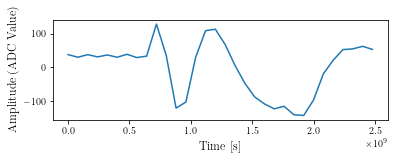

In [158]:
plt.xlabel(r'Time (Sampling Periods)',fontsize=12, labelpad=5)
plt.ylabel(r'Amplitude (ADC Value)',fontsize=12)
plt.plot(out.residual)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-3,4), useMathText=True)
axes=plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * ratio)
plt.savefig('plots/exp_res.pdf', bbox_inches = 'tight')
plt.show()

## Exponential with reflection fitting

In [153]:
model = lmfit.Model(phast_functions.crrcn)
pars = model.make_params()
pars.add(name='N',      value=2, vary=False,    min=2,   max=2.1)
pars.add(name='t0',     value=7, vary=True,     min=5,  max=20)
pars.add(name='amp',    value=2000, vary=True,     min=1500,  max=5000)
pars.add(name='tau',    value=1.4, vary=True,     min=0.3,  max=2.3)
pars.add(name='offset', value=50, vary=True,     min=30,  max=70)
pars.add(name='dt', value=7.49, vary=True,     min=3,  max=10)
pars.add(name='k', value=0.15, vary=True,     min=0.01,  max=0.2)
#method = 'DifferentialEvolution'
init = model.eval(pars, x = x)
out = model.fit(exp_data, params= pars, x=x, method= method)
comps = out.eval_components(x = x)

plt.plot(exp_data, label='Experimental pulse')
plt.xlabel(r'Time (Sampling Periods)',fontsize=12, labelpad=5)
plt.ylabel(r'Amplitude (ADC Value)',fontsize=12)
plt.plot(out.best_fit, 'r', label='Fitted curve')
plt.legend(loc='best')
axes.ticklabel_format(axis='y', style='sci', scilimits=(-3,4), useMathText=True)

axes= plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * ratio)
plt.savefig('plots/exp_ref_fit.pdf', bbox_inches = 'tight')

plt.show()
print(out.fit_report())

[[Model]]
    Model(crrcn)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 157
    # data points      = 32
    # variables        = 6
    chi-square         = 35651.0026
    reduced chi-square = 1371.19241
    Akaike info crit   = 236.505493
    Bayesian info crit = 245.299908
[[Variables]]
    N:       2 (fixed)
    t0:      8.56588361 +/- 0.04806070 (0.56%) (init = 7)
    amp:     1996.33237 +/- 23.2123091 (1.16%) (init = 2000)
    tau:     1.79754543 +/- 0.02995571 (1.67%) (init = 1.4)
    offset:  43.6125007 +/- 10.1890499 (23.36%) (init = 50)
    k:       0.10095161 +/- 0.01176178 (11.65%) (init = 0.15)
    dt:      8.00216604 +/- 0.30939614 (3.87%) (init = 7.49)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, tau)     = -0.816
    C(tau, dt)     =  0.483
    C(tau, k)      = -0.434
    C(amp, offset) = -0.368
    C(amp, tau)    = -0.368
    C(t0, dt)      = -0.355
    C(tau, offset) = -0.348
    C(t0, offset)  =  0.348
    C(offset, k

In [154]:
plt.xlabel(r'Time (Sampling Periods)',fontsize=12, labelpad=5)
plt.ylabel(r'Amplitude (ADC Value)',fontsize=12)
plt.plot(out.residual)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-3,4), useMathText=True)
axes=plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * ratio)
plt.savefig('plots/exp_ref_res.pdf', bbox_inches = 'tight')
plt.show()

## Bi-exponential fitting

In [155]:
model = lmfit.Model(phast_functions.math_model)
pars = model.make_params()
pars.add(name='N',      value=2, vary=False,    min=2,   max=2.1)
pars.add(name='t0',     value=7, vary=True,     min=5,  max=20)
pars.add(name='amp',    value=2000, vary=True,     min=1500,  max=5000)
pars.add(name='tau',    value=1.4, vary=True,     min=0.3,  max=2.3)
pars.add(name='offset', value=50, vary=True,     min=30,  max=70)
pars.add(name='dt', value=7.49, vary=True,     min=3,  max=10)
pars.add(name='k', value=0.15, vary=True,     min=0.01,  max=0.2)
#method = 'DifferentialEvolution'
init = model.eval(pars, x = x)
out = model.fit(exp_data, params= pars, x=x, method= method)
comps = out.eval_components(x = x)

plt.plot(y, exp_data, label='Experimental pulse')
plt.xlabel(r'Time (Sampling Periods)',fontsize=12, labelpad=5)
plt.ylabel(r'Amplitude (ADC Value)',fontsize=12)
plt.plot(y, out.best_fit, 'r', label='Fitted curve')
plt.legend(loc='best')
axes.ticklabel_format(axis='y', style='sci', scilimits=(-3,4), useMathText=True)

axes= plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * ratio)
plt.savefig('plots/bi-exp_ref_fit.pdf', bbox_inches = 'tight')

plt.show()
print(out.fit_report())

[[Model]]
    Model(math_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 32
    # variables        = 6
    chi-square         = 43356.7056
    reduced chi-square = 1667.56560
    Akaike info crit   = 242.767384
    Bayesian info crit = 251.561800
[[Variables]]
    N:       2 (fixed)
    t0:      8.09316294 +/- 0.06553986 (0.81%) (init = 7)
    amp:     2016.71601 +/- 26.0821794 (1.29%) (init = 2000)
    tau:     1.61811965 +/- 0.03059830 (1.89%) (init = 1.4)
    offset:  46.4908866 +/- 11.0184455 (23.70%) (init = 50)
    k:       0.12554939 +/- 0.01317201 (10.49%) (init = 0.15)
    dt:      7.55340703 +/- 0.28614609 (3.79%) (init = 7.49)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, tau)     = -0.875
    C(tau, dt)     =  0.492
    C(tau, k)      = -0.460
    C(t0, dt)      = -0.397
    C(amp, tau)    = -0.388
    C(t0, offset)  =  0.349
    C(amp, offset) = -0.347
    C(tau, offset) = -0.346
    C(t0, a

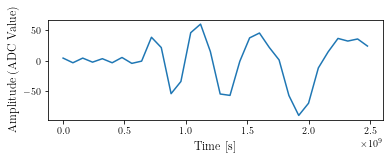

In [156]:
plt.xlabel(r'Time (Sampling Periods)',fontsize=12, labelpad=5)
plt.ylabel(r'Amplitude (ADC Value)',fontsize=12)
plt.plot(out.residual)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-3,4), useMathText=True)
axes=plt.gca()
axes.set_aspect(1.0/axes.get_data_ratio() * ratio)
plt.savefig('plots/bi-exp_ref_res.pdf', bbox_inches = 'tight')
plt.show()

# Heatmaps

Run,Spill,Event,X,Y,Barycenter,peak_amp,Mean,Std,N,t0,amp,tau,offset,k,dt,bic,chisqr,d00,d01,d02,d03,d04,d05,d06,d07,d08,d09,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31r00,r01,r02,r03,r04,r05,r06,r07,r08,r09,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20,r21,r22,r23,r24,r25,r26,r27,r28,r29,r30,r31

## Create image

In [138]:
import dask.array as da
import dask.dataframe as df
import os
import glob

headers = ['Frequency','Max','Barycenter', 'Mean', 'Std', 't0', 'amp', 'tau', 'offset', 'k', 't1', 'bic']
t = len(headers)

reader = df.read_csv('data/fit_202103*.csv', 
    usecols = list(range(3,82))
    #dtype = {'X':str, 'Y':str}
    ).drop(['N','bic', *get_arr('d')], axis= 1).astype({'X': 'str', 'Y': 'str'})
reader['XY'] = (reader['X'] + ',' + reader['Y'])
reader['rstd'] = reader[['r00','r31']].std(axis=1)

## Frequency

In [86]:
heat_map(reader['XY'].value_counts().compute().to_dict(), 'turbo', 'frequency', True, blabel= 'Counts')

## Max

In [ ]:
heat_map(reader.groupby('XY').peak_amp.max().compute().to_dict(), 'turbo', 'max', True, blabel='ADC Value')

## Barycenter

In [ ]:
heat_map((reader.groupby('XY').Barycenter.mean()/sample_rate).compute().to_dict(), 'turbo','barycenter', blabel= 'Time (Sampling Periods)')

## Mean

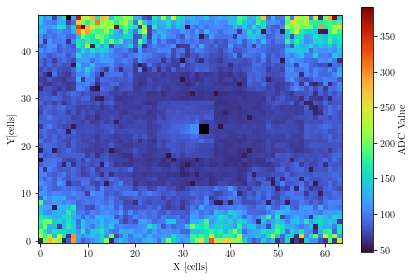

In [ ]:
heat_map(reader.groupby('XY').Mean.mean().compute().to_dict(), 'turbo', 'mean', blabel= 'ADC Value')

## Standard Deviation

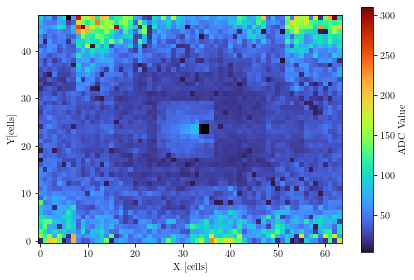

In [ ]:
heat_map(reader.groupby('XY').Std.mean().compute().to_dict(), 'turbo', 'std', blabel= 'ADC Value')

## Arrival time  

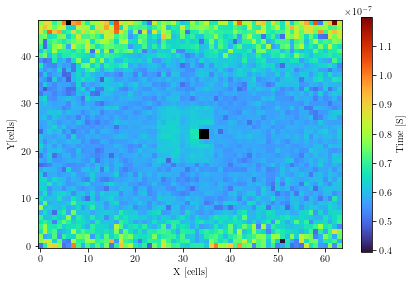

In [ ]:
heat_map((reader.groupby('XY').t0.mean()/sample_rate).compute().to_dict(), 'turbo', 't0', blabel='Time (Sampling Periods)')

## Amplitude 

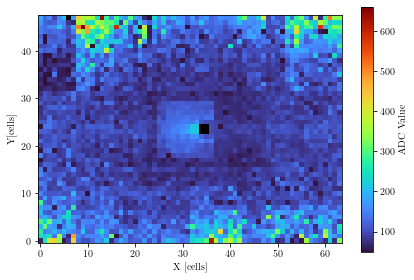

In [ ]:
heat_map(reader.groupby('XY').amp.mean().compute().to_dict(), 'turbo', 'amp', blabel= 'ADC Value')

## Exponential time tau

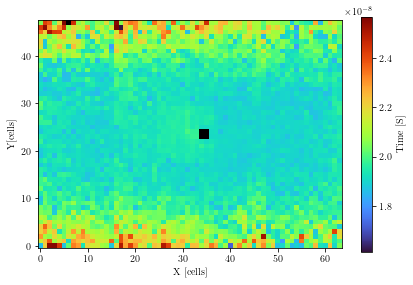

In [ ]:
heat_map((reader.groupby('XY').tau.mean()/sample_rate).compute().to_dict(), 'turbo', 'tau', blabel= 'Time (Sampling Periods)')


## Offset 

In [ ]:
heat_map(reader.groupby('XY').offset.mean().compute().to_dict(), 'turbo', 'offset', blabel= 'ADC Value')

## Reflection amplitude percentaje k

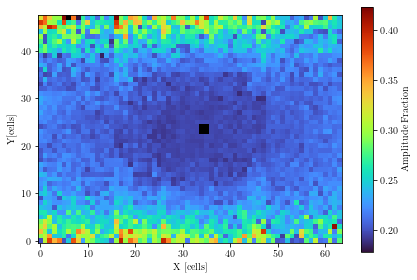

In [ ]:
heat_map(reader.groupby('XY').k.mean().compute(), 'turbo', 'k', blabel= 'Amplitude Fraction')

## Relfection delay time t1

In [ ]:
heat_map((reader.groupby('XY').dt.mean()/sample_rate).compute(), 'turbo', 't1', blabel= 'Time (Sampling Periods)')

## Chi square

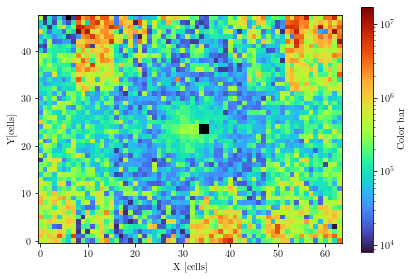

In [87]:
heat_map(reader.groupby('XY').chisqr.mean().compute(), 'turbo', 'chi', True)

## Residuals standard deviation mean value by channel

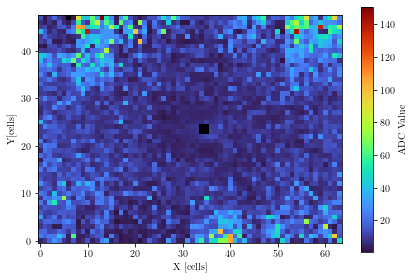

In [141]:
heat_map(reader.groupby('XY').rstd.mean().compute(), 'turbo', 'rstd', blabel="ADC Value" )